# Analyze Health Data

-----

## Backlog

- Base predictions on pace for last N days
- add vertical lines to mark surgery & novo start dates
- bar charts with steps/workouts side by side
- Total mileage for runs/walks/rides
- Aggregate stairmaster, eliptical, rower, etc...
- Build model of steps per mile
- ideally create single merged data table of daily fitness stats
- Workout data
- calories
- Mindfulness
- VO2max
- Integrate w/strava
- Need strava data to get calories from cycling workouts I think.

## Dependencies and Libraries

In [1]:
from datetime import date, datetime, timedelta as td
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
%matplotlib inline

## Data Extraction

In [2]:
%run -i 'apple-health-data-parser' 'data/export.xml'

Reading data from data/export.xml . . . done


apple-health-data-parser.py:136: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  self.nodes = self.root.getchildren()


Unexpected node of type ExportDate.

Tags:
ActivitySummary: 687
ExportDate: 1
Me: 1
Record: 1369942
Workout: 254

Fields:
HKCharacteristicTypeIdentifierBiologicalSex: 1
HKCharacteristicTypeIdentifierBloodType: 1
HKCharacteristicTypeIdentifierDateOfBirth: 1
HKCharacteristicTypeIdentifierFitzpatrickSkinType: 1
activeEnergyBurned: 687
activeEnergyBurnedGoal: 687
activeEnergyBurnedUnit: 687
appleExerciseTime: 687
appleExerciseTimeGoal: 687
appleStandHours: 687
appleStandHoursGoal: 687
creationDate: 1370196
dateComponents: 687
device: 1353645
duration: 254
durationUnit: 254
endDate: 1370196
sourceName: 1370196
sourceVersion: 1365175
startDate: 1370196
totalDistance: 254
totalDistanceUnit: 254
totalEnergyBurned: 254
totalEnergyBurnedUnit: 254
type: 1369942
unit: 1358654
value: 1369689
workoutActivityType: 254

Record types:
ActiveEnergyBurned: 633668
AppleExerciseTime: 24673
AppleStandHour: 11032
AppleStandTime: 5198
AudioExposureEvent: 2
BasalEnergyBurned: 205104
BodyMass: 342
DietaryCalciu

------

## Steps

In [3]:
steps = pd.read_csv("data/StepCount.csv")
# steps.tail()

### Correct time zone to EST and capture time properties

In [4]:
###Check which of these elements is necessary here

# parse out date and time elements as EST time
steps['startDate'] = pd.to_datetime(steps['startDate'], utc=True).dt.tz_convert('EST')
steps['endDate'] = pd.to_datetime(steps['endDate'], utc=True).dt.tz_convert('EST')
steps['date'] = steps['startDate'].dt.strftime('%Y-%m-%d')
steps['year_month'] = steps['startDate'].dt.strftime('%Y-%m')
steps['year'] = steps['startDate'].dt.year
steps['month'] = steps['startDate'].dt.month
steps['day'] = steps['startDate'].dt.day
steps['hour'] = steps['startDate'].dt.hour
steps['dow'] = steps['startDate'].dt.weekday
steps['doy'] = steps['startDate'].dt.dayofyear

#drop irrelevant columns
steps = steps.drop(['device', 'creationDate'], axis=1)
# steps.head()

### Use Only Watch Steps, Remove Phone Steps

In [5]:
# drop phone steps
steps = steps[steps.sourceName == 'Greg’s Apple\xa0Watch']
# steps.tail()

### Import Fitbit data

In [6]:
# Read fitbit csv
fb = pd.read_csv('data/fitbit_master.csv')

# parse out date and time elements as EST time
fb['Date'] = pd.to_datetime(fb['Date'])#.dt.tz_convert('EST')
fb['date'] = fb['Date'].dt.strftime('%Y-%m-%d')
fb['year_month'] = fb['Date'].dt.strftime('%Y-%m')
fb['year'] = fb['Date'].dt.year
fb['month'] = fb['Date'].dt.month
fb['day'] = fb['Date'].dt.day
fb['dow'] = fb['Date'].dt.weekday
fb['doy'] = fb['Date'].dt.dayofyear

# #drop irrelevant columns
# fb = fb.drop(['Date', 'Calories Burned', 'Distance', 'Floors', 'Minutes Sedentary', 'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active','Activity Calories'], axis=1)

fb2=fb[['date', 'Steps']]
#drop rows that overlap apple watch
fb2=fb2.iloc[:-2,:]

# fb.head()
# fb2.tail()

### Merge Fitbit Data

In [7]:
# Aggregate apple watch data by date
steps_by_date = steps.groupby(['date'])['value'].sum().reset_index(name='Steps')

#merge with fitbit data
steps_by_date = pd.concat([fb2, steps_by_date], ignore_index=True)

# print(steps_by_date.head())
print(steps_by_date.tail())

            date  Steps
1269  2020-04-24  25837
1270  2020-04-25  12791
1271  2020-04-26  23646
1272  2020-04-27  12548
1273  2020-04-28  15206


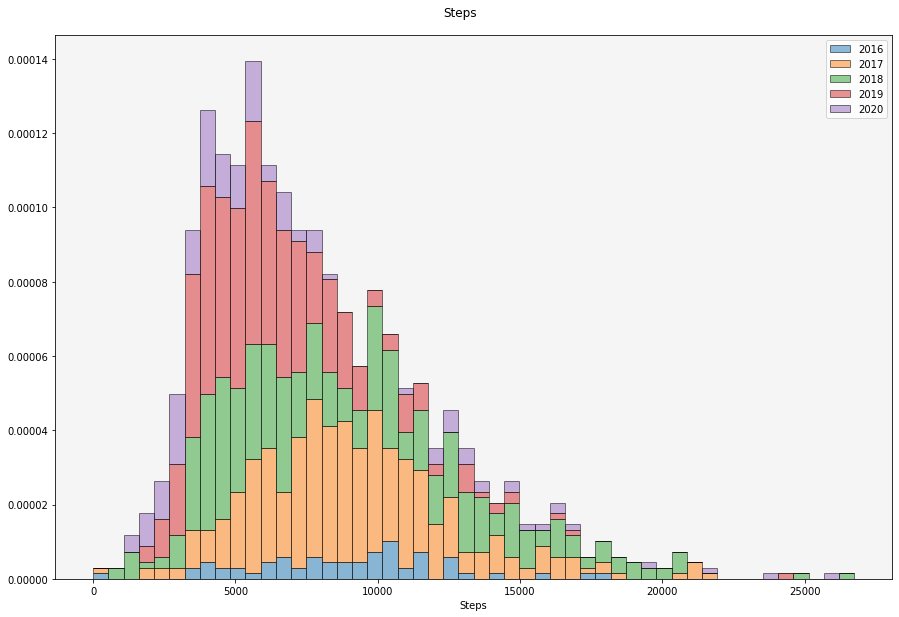

In [8]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])

#Specify distribution parameters
bn = 50

#plot histogram of steps
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
# n, bins, patches = plt.hist(df.Steps, bn, density=False, alpha =0.5, edgecolor='black')
# n, bins, patches = plt.hist(df[df.date.dt.year==2016].Steps, bn, density=False, alpha =0.9, label='2016', histtype='step')
# n, bins, patches = plt.hist(df[df.date.dt.year==2017].Steps, bn, density=False, alpha =0.9, label='2017', histtype='step')
# n, bins, patches = plt.hist(df[df.date.dt.year==2018].Steps, bn, density=False, alpha =0.9, label='2018', histtype='step')
# n, bins, patches = plt.hist(df[df.date.dt.year==2019].Steps, bn, density=False, alpha =0.9, label='2019', histtype='step')
# n, bins, patches = plt.hist(df[df.date.dt.year==2020].Steps, bn, density=False, alpha =0.9, label='2020', histtype='step')
n, bins, patches = plt.hist([df[df.date.dt.year==2016].Steps,df[df.date.dt.year==2017].Steps,df[df.date.dt.year==2018].Steps,df[df.date.dt.year==2019].Steps, df[df.date.dt.year==2020].Steps], bn, density=True, alpha =0.5, histtype='barstacked', label=['2016', '2017', '2018', '2019', '2020'], edgecolor='black')
plt.xlabel('Steps')
plt.legend(loc=1)
plt.show()

### Rolling average

In [9]:
steps_by_date2=steps_by_date.copy()
steps_by_date2['RollingMeanSteps'] = steps_by_date2.Steps.rolling(window=7, center=True).mean()

# steps_by_date2=steps_by_date2.dropna(axis=0)
steps_by_date2['date']=pd.to_datetime(steps_by_date2['date'])

steps_by_date2=steps_by_date2.set_index('date')

# print(steps_by_date2.head())
print(steps_by_date2.tail(20))

            Steps  RollingMeanSteps
date                               
2020-04-09   3075       6135.857143
2020-04-10   4247       6897.714286
2020-04-11  12625       8120.142857
2020-04-12   6458       7999.571429
2020-04-13   7622       9400.857143
2020-04-14  16982      11850.714286
2020-04-15   4988      11767.285714
2020-04-16  12884      12762.000000
2020-04-17  21396      13754.714286
2020-04-18  12041      13692.142857
2020-04-19  13421      15307.000000
2020-04-20  14571      15307.428571
2020-04-21  16544      15941.857143
2020-04-22  16292      16049.000000
2020-04-23  12887      17509.714286
2020-04-24  25837      17220.714286
2020-04-25  12791      17029.571429
2020-04-26  23646               NaN
2020-04-27  12548               NaN
2020-04-28  15206               NaN


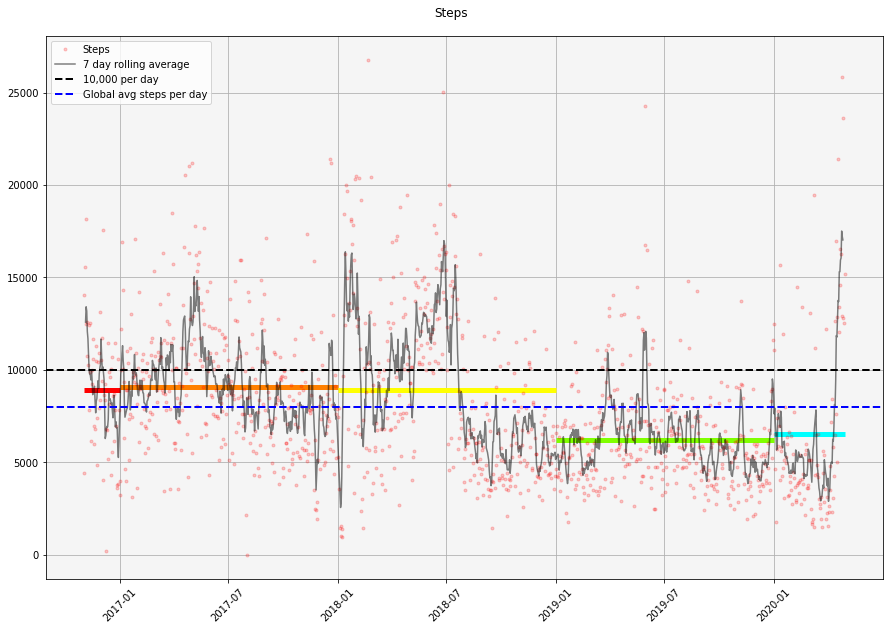

In [10]:
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_date2['Steps'], 'r.', alpha=0.2,label='Steps')
plt.plot(steps_by_date2['RollingMeanSteps'], c='k',label='7 day rolling average', alpha=0.5)

ax.axhline(10000, linewidth=2, color='k', linestyle='dashed',label="10,000 per day")
ax.axhline(steps_by_date2.Steps.mean(), linewidth=2, color='blue', linestyle='dashed',label="Global avg steps per day")

# ax.axhline(steps_by_date2.resample('Y').mean().iloc[0,0],xmin=steps_by_date2.index.min(), xmax=steps_by_date2.resample('Y').mean().index[0], linewidth=2, color='r', linestyle='dashed')

plt.hlines(steps_by_date2.resample('Y').mean().iloc[0,0],steps_by_date2.index.min(), steps_by_date2.resample('Y').mean().index[0], colors=(1,0,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[1,0],steps_by_date2.resample('Y').mean().index[0], steps_by_date2.resample('Y').mean().index[1], colors=(1,0.5,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[2,0],steps_by_date2.resample('Y').mean().index[1], steps_by_date2.resample('Y').mean().index[2], colors=(1,1,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[3,0],steps_by_date2.resample('Y').mean().index[2], steps_by_date2.resample('Y').mean().index[3], colors=(0.5,1,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[4,0],steps_by_date2.resample('Y').mean().index[3], steps_by_date2.index.max(), colors=(0,1,1,1), linewidths=(5,))

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()
# print(steps_by_date2.index.min())
# print(steps_by_date2.resample('Y').mean().index[0])

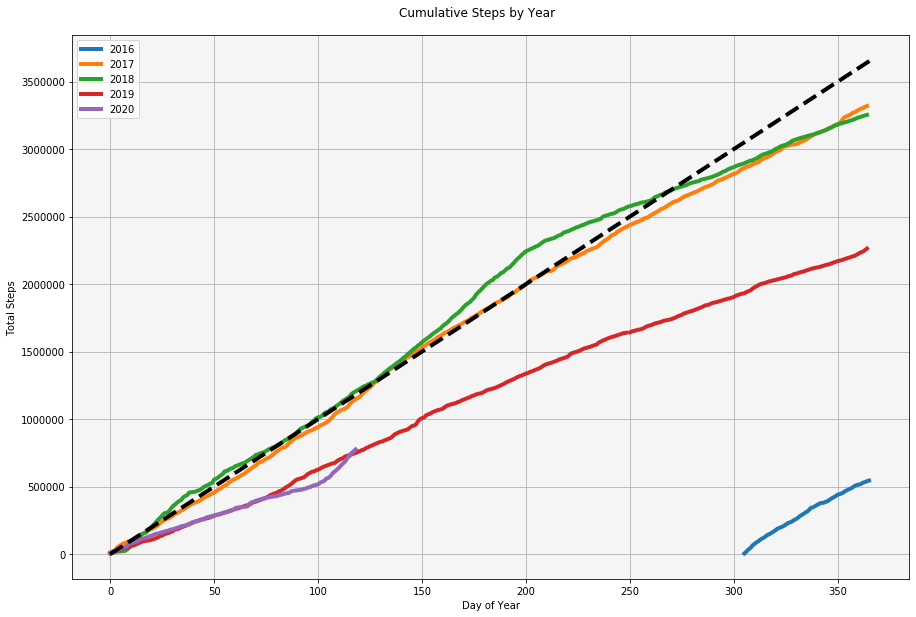

In [11]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['doy'] = df['date'].dt.dayofyear

steps_by_year = pd.pivot_table(df, index='doy', columns='year', values='Steps', aggfunc='sum').reset_index().rename_axis(None, axis=1)

plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Cumulative Steps by Year', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_year[2016].cumsum(), label='2016', linewidth=4)
plt.plot(steps_by_year[2017].cumsum(), label='2017', linewidth=4)
plt.plot(steps_by_year[2018].cumsum(), label='2018', linewidth=4)
plt.plot(steps_by_year[2019].cumsum(), label='2019', linewidth=4)
plt.plot(steps_by_year[2020].cumsum(), label='2020', linewidth=4)

x1, y1 = [0,366], [0,3660000]
plt.plot(x1,y1, linewidth = 4, linestyle='dashed', c='k')

plt.ylabel("Total Steps")
plt.xlabel("Day of Year")
plt.legend(loc=2)
# plt.xticks(rotation=45)

plt.show()

In [37]:
### Steps needed to get on track

#Yearly averages
yearly_totals = steps_by_date.copy()
yearly_totals['date']=pd.to_datetime(yearly_totals['date'])
yearly_totals=yearly_totals.set_index('date')
yearly_totals =yearly_totals['Steps'].resample('Y').sum()
# print(yearly_totals)

# Calc 7-day rolling mean
zz = steps_by_date.copy()
zz['date']=pd.to_datetime(zz['date'])
zz=zz.set_index('date')
rolling7 = math.floor(zz.iloc[-7:].Steps.mean())
print('My 7-day rolling step mean is:', rolling7,"\n")

#Current DOY
doy = datetime.today().timetuple().tm_yday#.strftime('%Y-%m-%d')

print("Today is the {}th day of {}.\n".format(doy, yearly_totals.index[-1].year))

# print("Every {} extra steps today makes up for 1 step on my average for the year so far\n".format(doy))

print("I am currently averaging {} steps per day (SPD) for {}.\n".format(math.ceil(yearly_totals.iloc[-1]/doy), yearly_totals.index[-1].year))

print("I am {} steps behind what I need to be at a 10,000 SPD average.\n".format((doy*10000-yearly_totals.iloc[-1])))
print("This is equivalent to being {} days behind.\n".format(round((doy*10000-yearly_totals.iloc[-1])/10000, 1)))

print("To reach 10,000 SPD I will need to walk {} steps per day for the rest of the year.\n".format(math.ceil((3652500-yearly_totals.iloc[-1])/(365.25-doy))))

print("My global average {} SPD.".format(round(steps_by_date2.Steps.mean(),1)))
print("I need to make up {:,} steps for my current SPD to match the global average.".format(math.ceil((steps_by_date2.Steps.mean()-yearly_totals.iloc[-1]/doy)*doy)))
print("To beat my global average I will need to walk {} SPD for the rest of the year.".format(math.ceil(((steps_by_date2.Steps.mean()*365.25)-yearly_totals.iloc[-1])/(365.25-doy))))
print("I need to walk {} extra steps to raise my global average by 1 step.".format((steps_by_date2.index[-1]-steps_by_date2.index[0]).days))
print("To reach a global average of 10,000 SPD I need to make up {:,} steps.\n".format(steps_by_date2.shape[0]*10000-steps_by_date2.Steps.sum()))

print("My {} average was {} SPD.".format(yearly_totals.index[1].year, round(yearly_totals.iloc[1]/365.25, 1)))
print("I need to make up {:,} steps for my current SPD to match {}.".format(math.ceil((yearly_totals.iloc[1]/365.25-yearly_totals.iloc[-1]/doy)*doy), yearly_totals.index[1].year))
print("To beat my {} average I will need to walk {} SPD for the rest of the year.".format(yearly_totals.index[1].year, math.ceil((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(365.25-doy))))
print("At my current {} SPD pace I will catch {}'s total in {} days on doy {}.".format(math.ceil(yearly_totals.iloc[-1]/doy), yearly_totals.index[1].year, round((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy),1), math.ceil(doy+(yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy))))
print("At my current 7-day avg SPD pace of {} I will catch {}'s total in {} days on doy {}.\n".format(rolling7, yearly_totals.index[1].year, math.ceil((yearly_totals.iloc[1]/rolling7)), math.ceil(doy+math.ceil((yearly_totals.iloc[1]/rolling7)))))

print("My {} average was {} SPD".format(yearly_totals.index[2].year, round(yearly_totals.iloc[2]/365.25, 1)))
print("I need to make up {:,} steps for my current SPD to match {}.".format(math.ceil((yearly_totals.iloc[2]/365.25-yearly_totals.iloc[-1]/doy)*doy), yearly_totals.index[2].year))
print("To beat my {} average I will need to walk {} SPD for the rest of the year.".format(yearly_totals.index[2].year, math.ceil((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(365.25-doy))))
print("At my current {} SPD pace I will catch {}'s total in {} days on doy {}.".format(math.ceil(yearly_totals.iloc[-1]/doy), yearly_totals.index[2].year, round((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy),1), math.ceil(doy+(yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy))))
print("At my current 7-day avg SPD pace of {} I will catch {}'s total in {} days on doy {}.\n".format(rolling7, yearly_totals.index[2].year, math.ceil((yearly_totals.iloc[2]/rolling7)), math.ceil(doy+math.ceil((yearly_totals.iloc[2]/rolling7)))))


print("My {} average was {} SPD".format(yearly_totals.index[3].year, round(yearly_totals.iloc[3]/365.25, 1)))
print("I need to make up {:,} steps for my current SPD to match {}.".format(math.ceil((yearly_totals.iloc[3]/365.25-yearly_totals.iloc[-1]/doy)*doy), yearly_totals.index[3].year))
print("To beat my {} average I will need to walk {} SPD for the rest of the year.".format(yearly_totals.index[3].year, math.ceil((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(365.25-doy))))
print("At my current {} SPD pace I will catch {}'s total in {} days on doy {}.".format(math.ceil(yearly_totals.iloc[-1]/doy), yearly_totals.index[3].year, round((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy),1), math.ceil(doy+(yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy))))
print("At my current 7-day avg SPD pace of {} I will catch {}'s total in {} days on doy {}.".format(rolling7, yearly_totals.index[3].year, math.ceil((yearly_totals.iloc[3]/rolling7)), math.ceil(doy+math.ceil((yearly_totals.iloc[3]/rolling7)))))


# Steps to get global to 10000

My 7-day rolling step mean is: 17029 

Today is the 119th day of 2020.

I am currently averaging 6514 steps per day (SPD) for 2020.

I am 414858 steps behind what I need to be at a 10,000 SPD average.

This is equivalent to being 41.5 days behind.

To reach 10,000 SPD I will need to walk 11685 steps per day for the rest of the year.

My global average 7969.8 SPD.
I need to make up 173,261 steps for my current SPD to match the global average.
To beat my global average I will need to walk 8674 SPD for the rest of the year.
I need to walk 1274 extra steps to raise my global average by 1 step.
To reach a global average of 10,000 SPD I need to make up 2,586,513 steps.

My 2017 average was 9086.3 SPD.
I need to make up 306,126 steps for my current SPD to match 2017.
To beat my 2017 average I will need to walk 10330 SPD for the rest of the year.
At my current 6514 SPD pace I will catch 2017's total in 390.5 days on doy 510.
At my current 7-day avg SPD pace of 17029 I will catch 2017's total i

------

## Monthly Steps

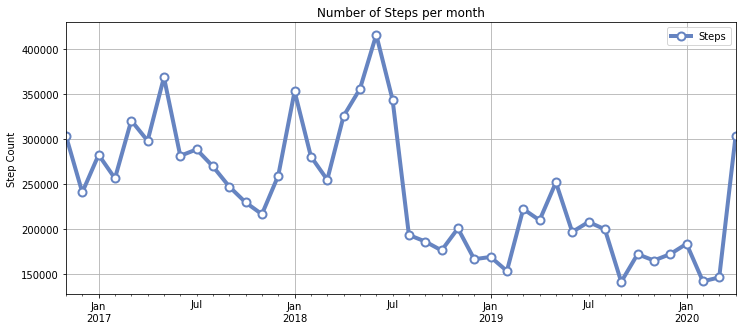

415861

In [13]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
df=df.set_index('date')
df = df.resample('M').sum()
# df.head()

chart_title = 'Number of Steps per month'

ax = df.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_xlabel('')
ax.set_title(chart_title)

plt.show()
df.Steps.max()

## Steps By Year

year
2016    303611.0
2017    368655.0
2018    415861.0
2019    251924.0
2020    302997.0
dtype: float64


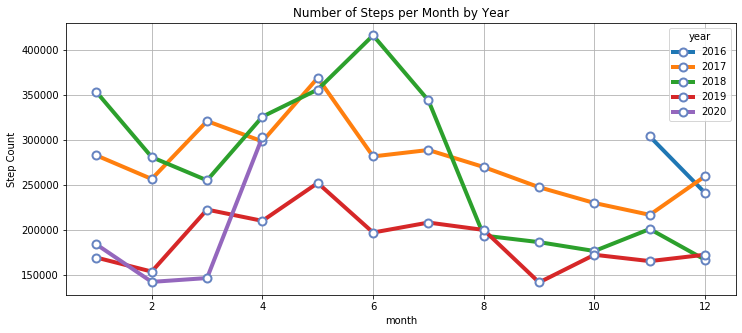

In [14]:
# Group data by year in pivot table
df2 = steps_by_date.copy()
df2['date'] = pd.to_datetime(df2['date'])
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month

df3 = pd.pivot_table(df2, index='month', columns='year', values='Steps', aggfunc='sum')
chart_title = 'Number of Steps per Month by Year'

ax = df3.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_title(chart_title)

print(df3.max())
# print(df3.head())

plt.show()

----

-----

## Weight Data

In [15]:
#import apple data
weight = pd.read_csv("data/BodyMass.csv")
#keep only apple health data (the rest are copies)
weight = weight[weight.sourceName=='Health']
#sort and reindex
weight = weight.sort_values(by='startDate', ignore_index=True)

# parse out date and time elements as EST time
weight['startDate'] = pd.to_datetime(weight['startDate'], utc=True).dt.tz_convert('EST')
weight['endDate'] = pd.to_datetime(weight['endDate'], utc=True).dt.tz_convert('EST')
weight['date'] = weight['startDate'].dt.strftime('%Y-%m-%d')

# drop duplicates
weight.drop_duplicates(subset = 'date', keep='last', ignore_index=True, inplace=True)

#drop irrelevant columns and rename value to Weight
weight = weight[['value','date']]
weight.rename(columns={'value':'Weight'}, inplace=True)

# weight.head(10)

In [16]:
#import fitbit weight data
weight2 = pd.read_csv("data/fitbit_weight.csv")

weight2['Date'] = pd.to_datetime(weight2['Date'])
weight2['date'] = weight2['Date'].dt.strftime('%Y-%m-%d')
weight2 = weight2.drop(['Date','BMI'], axis=1)

# weight2.head(10)

In [17]:
#merge with fitbit data
# print(weight.shape)
weight = pd.concat([weight2,weight], ignore_index=True)
# print(weight.shape)
# weight.tail()

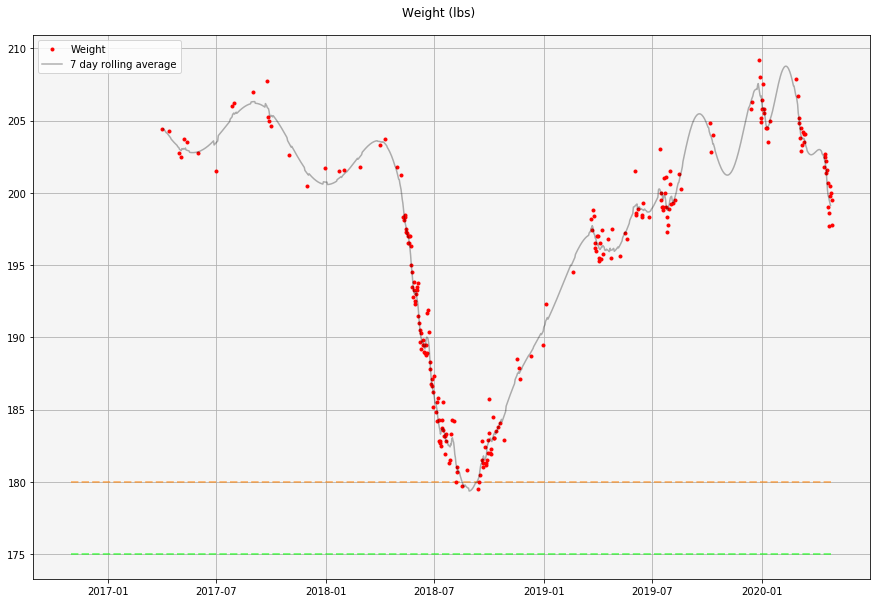

In [18]:
# parse out date and time elements
weight3 =weight.copy()
weight3['Date'] = pd.to_datetime(weight3['date'])

#sort by date and reindex
weight3 = weight3.sort_values(by='Date', ignore_index=True)

#set Date as index
weight3 = weight3.drop('date', axis=1).set_index('Date')

#resample by day and interpolate missing values using splines
weight4 = weight3.resample('D').interpolate(method='spline', order = 4, axis = 0)
# print(weight3.shape)

#create a 7day rolling average
weight4['rolling_avg']=weight4.rolling(window=7, center=True).mean()

#plot it
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Weight (lbs)', fontsize=12, y=.92)
plt.grid(True)
plt.plot(weight3['Weight'], 'r.', alpha=1,label='Weight')
plt.plot(weight4['rolling_avg'], c='k', alpha=0.3,label='7 day rolling average')

plt.hlines(180,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed', colors=(1,.5,0,0.5), linewidths=(2,))
plt.hlines(175,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed', colors=(0,1,0,0.5), linewidths=(2,))

plt.legend(loc=2)

plt.show()

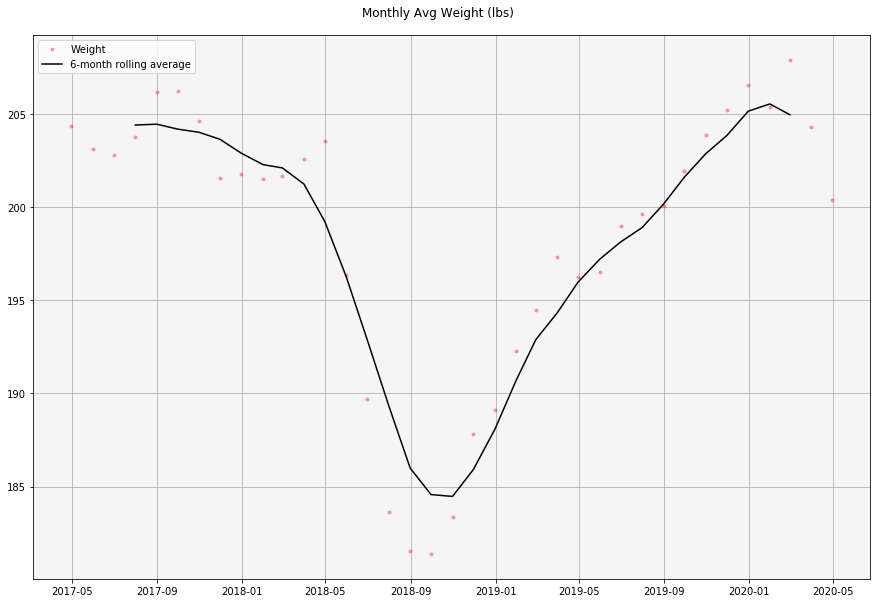

In [19]:
# parse out date and time elements
weight2 =weight.copy()
weight2['Date'] = pd.to_datetime(weight2['date'])

#sort by date and reindex
weight2 = weight2.sort_values(by='Date', ignore_index=True)

#set Date as index
weight2 = weight2.drop('date', axis=1).set_index('Date')

#resample by day and interpolate missing values using splines
weight2 = weight2.resample('M').mean().interpolate(method='linear', axis = 0)
# print(weight2.shape)

#create a 6-month rolling average
weight2['rolling_avg']=weight2.rolling(window=6, center=True).mean()

plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Monthly Avg Weight (lbs)', fontsize=12, y=.92)
plt.grid(True)
plt.plot(weight2['Weight'], 'r.', alpha=0.3,label='Weight')
plt.plot(weight2['rolling_avg'], c='k',label='6-month rolling average')
plt.legend(loc=2)
# plt.xticks(rotation=45)

plt.show()

## Heart Rate

----

### Resting Heart Rate

In [20]:
resting = pd.read_csv("data/RestingHeartRate.csv")
# print(resting.head())

# parse out date and time elements as EST time
resting['startDate'] = pd.to_datetime(resting['startDate'], utc=True).dt.tz_convert('EST')
resting['date'] = resting['startDate'].dt.strftime('%Y-%m-%d')

#Delete unnecessary columns
# resting = resting.drop(['sourceName', 'sourceVersion', 'device', 'type', 'unit', 'creationDate', 'startDate', 'endDate'], axis=1)
resting = resting[['date', 'value']]

print(resting.head())

         date  value
0  2018-06-17     59
1  2018-06-18     53
2  2018-06-19     57
3  2018-06-21     54
4  2018-06-20     57


In [21]:
#Creating daily average resting HR
resting_daily = resting.copy()
resting_daily = resting_daily.sort_values('date', ignore_index=True)
resting_daily = resting_daily.groupby(['date'])['value'].mean().reset_index(name='Resting_HR')
resting_daily['date'] = pd.to_datetime(resting_daily['date'])
resting_daily = resting_daily.set_index('date')
 
resting_daily = resting_daily.resample('D').interpolate(method='spline', order = 4, axis = 0)

print(resting_daily.head())

            Resting_HR
date                  
2018-06-17        59.0
2018-06-18        53.0
2018-06-19        57.0
2018-06-20        57.0
2018-06-21        54.0


In [22]:
#Add rolling average
resting_daily2 = resting_daily.copy()
resting_daily2['RollingHR_7'] = resting_daily2.Resting_HR.rolling(window=7, center = True).mean()
resting_daily2['RollingHR_30'] = resting_daily2.Resting_HR.rolling(window=30, center = True).mean()

resting_daily2 = resting_daily2.dropna(axis=0)

print(resting_daily2.head())

            Resting_HR  RollingHR_7  RollingHR_30
date                                             
2018-07-02        54.0    54.428571     55.046479
2018-07-03        51.0    55.428571     54.846479
2018-07-04        54.0    54.928571     54.913146
2018-07-05        55.0    55.633826     54.846479
2018-07-06        62.0    57.062398     54.746479


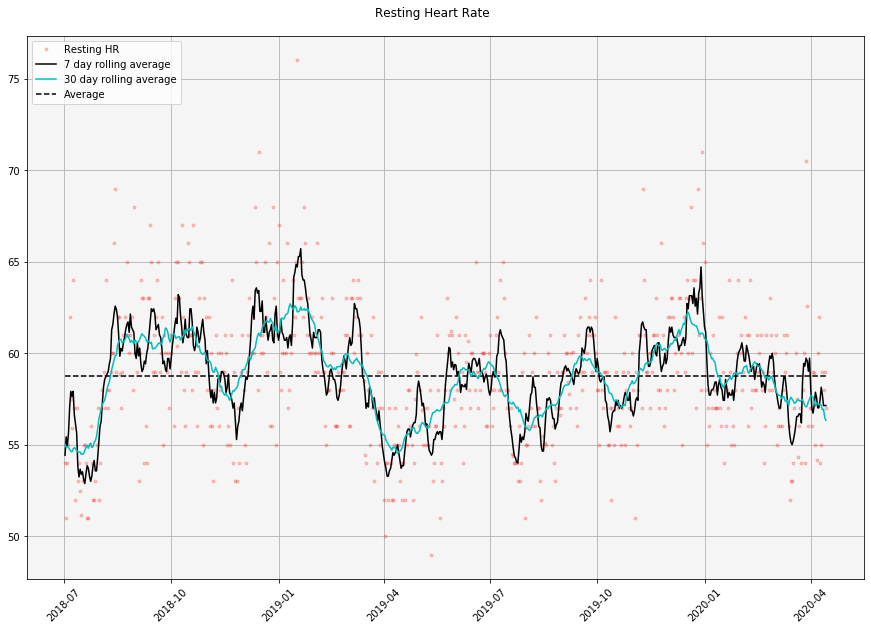

In [23]:
#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Resting Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(resting_daily2['Resting_HR'], 'r.', alpha=0.2,label='Resting HR')
plt.plot(resting_daily2['RollingHR_7'], c='k',label='7 day rolling average', alpha=1)
plt.plot(resting_daily2['RollingHR_30'], c='c',label='30 day rolling average', alpha=1)
plt.hlines(resting_daily2['Resting_HR'].mean(),resting_daily2.index.min(), resting_daily2.index.max(), label = 'Average', linestyles='dashed')

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

### Heart Rate

In [24]:
hr = pd.read_csv("data/HeartRate.csv")

# parse out date and time elements as EST time
hr['startDate'] = pd.to_datetime(hr['startDate'], utc=True).dt.tz_convert('EST')
# hr['date'] = hr['startDate'].dt.strftime('%Y-%m-%d')

#Delete unnecessary columns
hr = hr[['startDate', 'value']]

# hr.head()
# hr.tail()

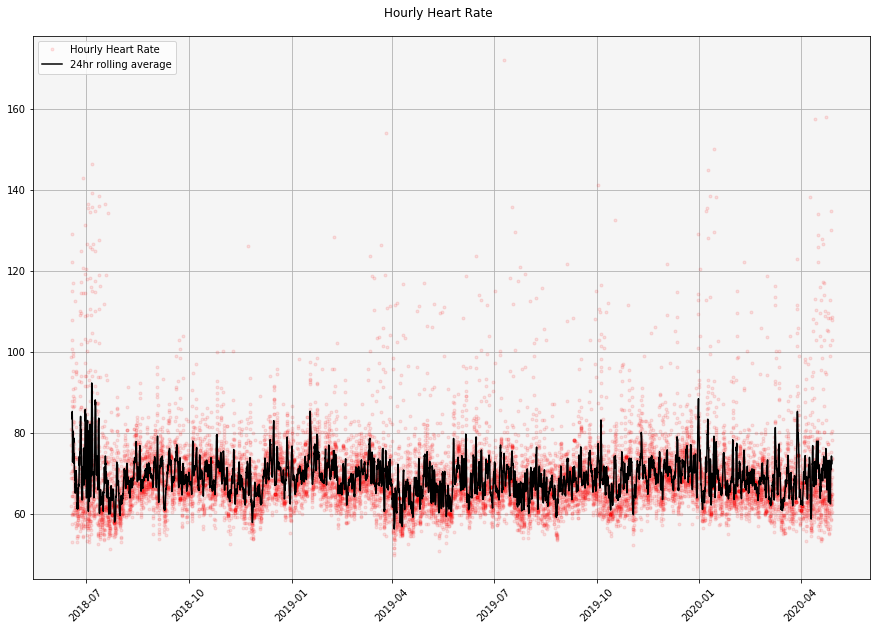

In [25]:
hr2 = hr.copy()
hr2 =hr2.sort_values('startDate', ignore_index=True)
hr2 = hr2.set_index('startDate')
hr2 = hr2.resample('H').mean()
hr2 = hr2.resample('H').interpolate(method='linear', axis = 0)

# print(hr2.head())

hr2['RollingHR'] = hr2.value.rolling(window=24, center = True).mean()

#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Hourly Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(hr2['value'], 'r.', alpha=0.1,label='Hourly Heart Rate')
plt.plot(hr2['RollingHR'], c='k',label='24hr rolling average', alpha=1)

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

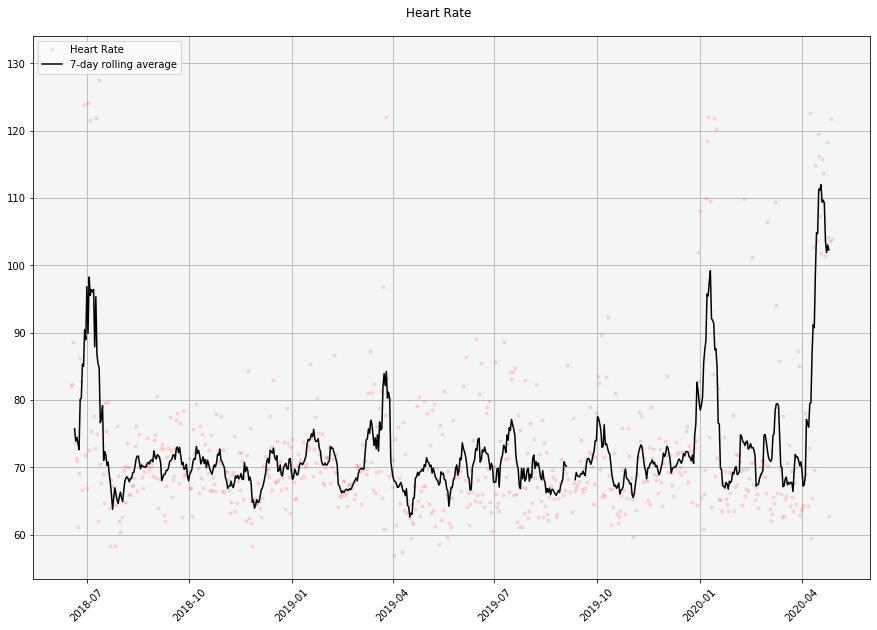

In [26]:
hr2 = hr.copy()
hr2 =hr2.sort_values('startDate', ignore_index=True)
hr2 = hr2.set_index('startDate')
hr2 = hr2.resample('D').mean()
# hr2 = hr2.resample('H').interpolate(method='linear', axis = 0)

# print(hr2.head())

hr2['RollingHR'] = hr2.value.rolling(window=7, center = True).mean()

#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(hr2['value'], 'r.', alpha=0.1,label='Heart Rate')
plt.plot(hr2['RollingHR'], c='k',label='7-day rolling average', alpha=1)

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

------

## Workout data 

In [27]:
Workout = pd.read_csv("data/Workout.csv")

# parse out date and time elements as EST time
Workout['startDate'] = pd.to_datetime(Workout['startDate'], utc=True).dt.tz_convert('EST')
Workout['endDate'] = pd.to_datetime(Workout['endDate'], utc=True).dt.tz_convert('EST')
Workout['date'] = Workout['startDate'].dt.strftime('%Y-%m-%d')

#Clean workout names
Workout['workoutActivityType'] = Workout['workoutActivityType'].str.replace('HKWorkoutActivityType','')

#round some feautures
Workout.duration = round(Workout.duration, 1)
Workout.totalEnergyBurned = round(Workout.totalEnergyBurned, 0)
Workout.totalDistance = round(Workout.totalDistance, 3)

#Delete unnecessary columns
Workout = Workout.drop(['sourceVersion', 'device', 'creationDate', 'durationUnit', 'totalDistanceUnit', 'totalEnergyBurnedUnit'], axis=1)

# Workout = Workout[['startDate', 'value']]

print(Workout.head(20))
# print(Workout.tail())
# print(Workout.shape)
# print(Workout.sourceName.unique())
# print(Workout.workoutActivityType.unique())

# print(Workout[Workout['sourceName']=='Strava'])


            sourceName                 startDate                   endDate  \
0   Greg’s Apple Watch 2018-06-17 19:35:27-05:00 2018-06-17 20:53:40-05:00   
1   Greg’s Apple Watch 2018-06-18 05:26:41-05:00 2018-06-18 06:25:12-05:00   
2   Greg’s Apple Watch 2018-06-18 19:34:24-05:00 2018-06-18 20:12:07-05:00   
3   Greg’s Apple Watch 2018-06-19 08:22:28-05:00 2018-06-19 08:42:41-05:00   
4   Greg’s Apple Watch 2018-06-19 13:09:58-05:00 2018-06-19 13:45:12-05:00   
5   Greg’s Apple Watch 2018-06-20 14:06:48-05:00 2018-06-20 15:16:20-05:00   
6   Greg’s Apple Watch 2018-06-21 19:27:20-05:00 2018-06-21 20:05:03-05:00   
7   Greg’s Apple Watch 2018-06-22 05:19:31-05:00 2018-06-22 06:29:26-05:00   
8   Greg’s Apple Watch 2018-06-23 13:51:09-05:00 2018-06-23 15:04:20-05:00   
9   Greg’s Apple Watch 2018-06-24 09:28:58-05:00 2018-06-24 10:59:55-05:00   
10              Strava 2018-06-25 05:30:39-05:00 2018-06-25 06:21:21-05:00   
11  Greg’s Apple Watch 2018-06-25 05:20:40-05:00 2018-06-25 06:2

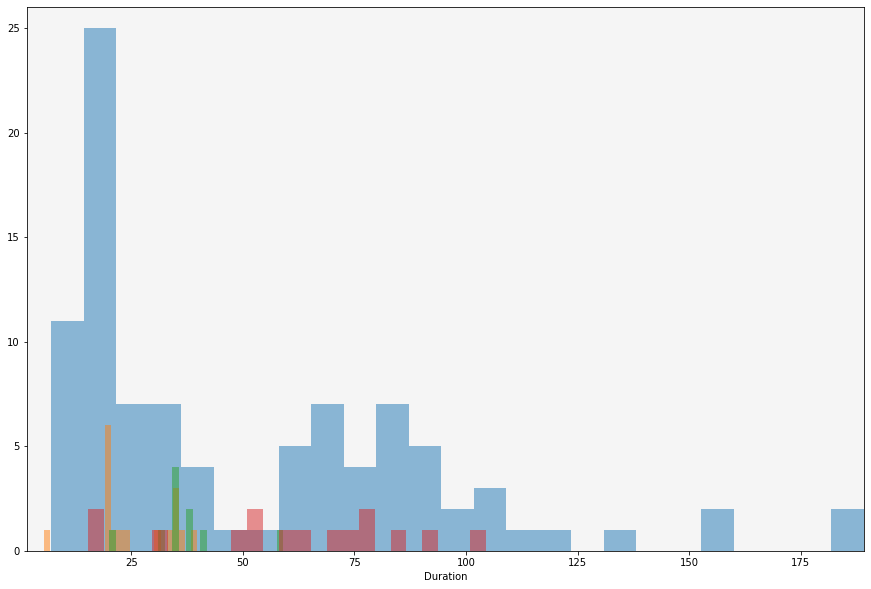

['Walking' 'Cycling' 'Tennis' 'Running' 'PaddleSports' 'Swimming' 'Yoga'
 'Elliptical' 'StairClimbing' 'Rowing' 'TraditionalStrengthTraining']


In [28]:
#Specify distribution parameters
bn = 25

plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

n, bins, patches = plt.hist(Workout.duration[Workout.workoutActivityType=='Walking'], bn, density=False, alpha =0.5)
n, bins, patches = plt.hist(Workout.duration[Workout.workoutActivityType=='Running'], bn, density=False, alpha =0.5)
n, bins, patches = plt.hist(Workout.duration[Workout.workoutActivityType=='Tennis'], bn, density=False, alpha =0.5)
n, bins, patches = plt.hist(Workout.duration[Workout.workoutActivityType=='Cycling'], bn, density=False, alpha =0.5)

plt.xlabel('Duration')
xmin, xmax, ymin, ymax = plt.axis()
plt.axis([Workout.duration.min(), Workout.duration.max(),0, 26])

plt.show()

# print(Workout.duration[Workout.workoutActivityType=='Walking'])
# print(Workout.duration.min())
# print(Workout.duration.max())
print(Workout.workoutActivityType.unique())


In [29]:
Workout2 = pd.pivot_table(Workout, index='date', columns='workoutActivityType', values='duration', aggfunc='sum').reset_index().rename_axis(None, axis=1)

# steps_by_year = pd.pivot_table(df, index='doy', columns='year', values='Steps', aggfunc='sum').reset_index().rename_axis(None, axis=1)

Workout2.head()


,date,Cycling,Elliptical,PaddleSports,Rowing,Running,StairClimbing,Swimming,Tennis,TraditionalStrengthTraining,Walking,Yoga
0,2018-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.2,NaN
1,2018-06-18,58.5,NaN,NaN,NaN,NaN,NaN,NaN,37.7,NaN,NaN,NaN
2,2018-06-19,NaN,NaN,NaN,NaN,20.2,NaN,NaN,35.2,NaN,NaN,NaN
3,2018-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.5,NaN
4,2018-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.7,NaN,NaN,NaN


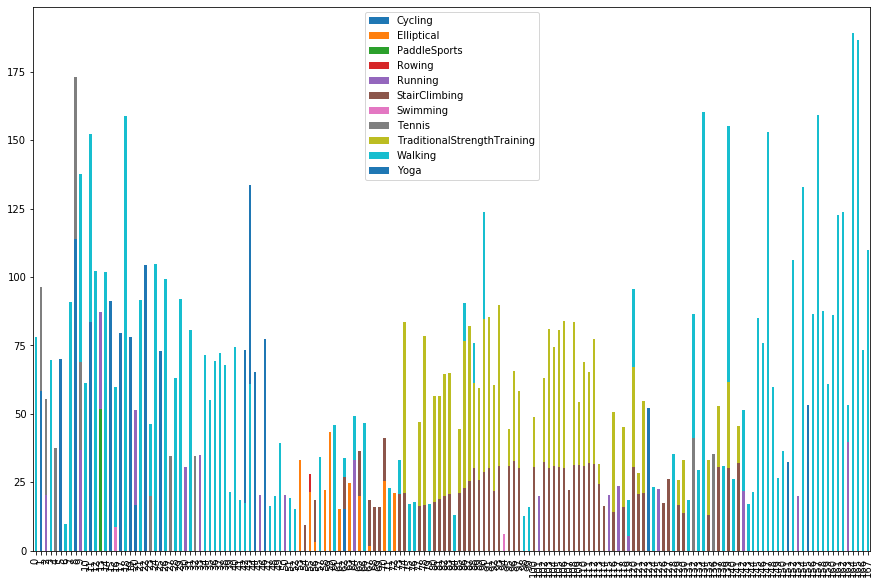

In [30]:
# pivot_df.loc[:,['Jan','Feb', 'Mar']].plot.bar(stacked=True, color=colors, figsize=(10,7))

Workout2.plot.bar(stacked=True, figsize=(15,10))


In [31]:
Workout3 = Workout.copy()
Workout3['steps'] = np.nan

for index, row in Workout3.iterrows():
    x = steps[(steps.startDate>=Workout3.startDate[index]) & (steps.endDate<=Workout3.endDate[index])]
    Workout3.steps[index] = x.value.sum()
    
Workout3['Steps_perMile'] = Workout3.steps/Workout3.totalDistance


# print(Workout3.iloc[0])
# x = steps[(steps.startDate>=Workout3.startDate[0]) & (steps.endDate<=Workout3.endDate[0])]# & steps[steps.endDate<=Workout3.endDate[0]]
# x = x[x.endDate<=Workout3.endDate[0]]


# print(steps.head())
# print(Workout3.head(25))
print(Workout3.tail(25))
# print(x)
# print('steps =',x.value.sum())

apple-health-data-parser.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


             sourceName                 startDate                   endDate  \
229  Greg’s Apple Watch 2020-03-08 16:32:12-05:00 2020-03-08 18:56:34-05:00   
230  Greg’s Apple Watch 2020-03-09 17:51:10-05:00 2020-03-09 18:51:03-05:00   
231  Greg’s Apple Watch 2020-03-11 18:23:45-05:00 2020-03-11 18:38:13-05:00   
232  Greg’s Apple Watch 2020-03-11 19:54:39-05:00 2020-03-11 20:06:40-05:00   
233  Greg’s Apple Watch 2020-03-15 17:16:30-05:00 2020-03-15 17:53:09-05:00   
234  Greg’s Apple Watch 2020-04-08 14:09:14-05:00 2020-04-08 14:41:40-05:00   
235  Greg’s Apple Watch 2020-04-11 11:11:30-05:00 2020-04-11 12:57:55-05:00   
236  Greg’s Apple Watch 2020-04-13 10:38:47-05:00 2020-04-13 10:59:00-05:00   
237  Greg’s Apple Watch 2020-04-14 12:09:14-05:00 2020-04-14 12:49:17-05:00   
238  Greg’s Apple Watch 2020-04-14 15:12:31-05:00 2020-04-14 16:45:18-05:00   
239  Greg’s Apple Watch 2020-04-15 15:25:16-05:00 2020-04-15 16:18:23-05:00   
240  Greg’s Apple Watch 2020-04-16 10:08:31-05:00 20

In [32]:
# 7978/3.888
print(Workout3[Workout3.workoutActivityType=='Walking'].Steps_perMile.mean())
print(Workout3[Workout3.workoutActivityType=='Running'].Steps_perMile.mean())


1728.8699326045535
1458.9426258197134


Walking - coefficient of determination: 0.974710770191789
Walking - intercept: 0.0
Walking - slope: [0.00051312]
Walking pace is [1948.8] steps per mile.

Running - coefficient of determination: 0.6231167844506826
Running - intercept: 0.0
Running - slope: [0.00068063]
Running pace is [1469.2] steps per mile.



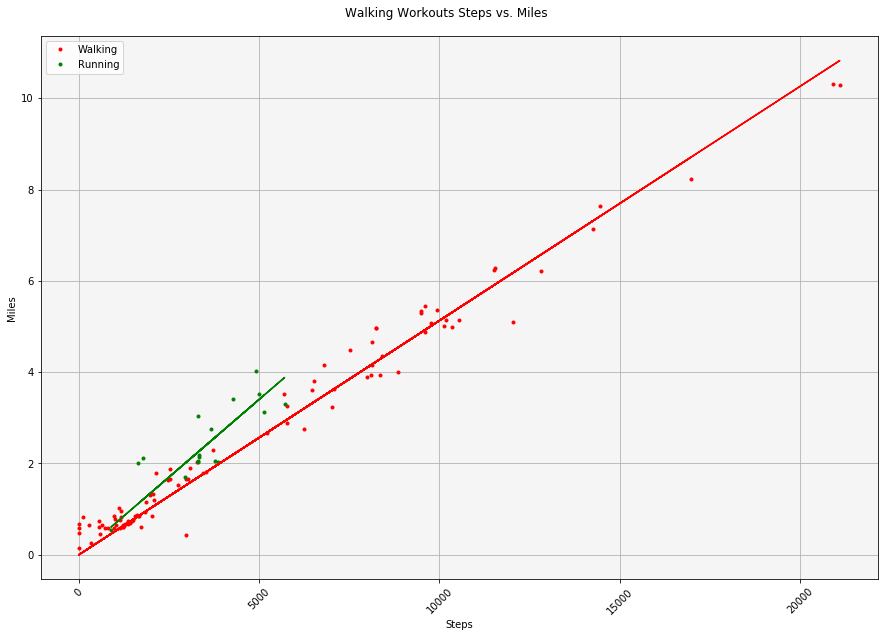

In [33]:
# Fit regression model for walking
x1 = Workout3[Workout3.workoutActivityType=='Walking'].steps.values.reshape((-1, 1))
y1 = Workout3[Workout3.workoutActivityType=='Walking'].totalDistance
model = LinearRegression(fit_intercept=False).fit(x1, y1)
r_sq = model.score(x1, y1)
y_pred = model.predict(x1)
print('Walking - coefficient of determination:', r_sq)
print('Walking - intercept:', model.intercept_)
print('Walking - slope:', model.coef_)
print('Walking pace is {} steps per mile.\n'.format(np.round(1/model.coef_,1)))

# Fit regression model for running
x2 = Workout3[Workout3.workoutActivityType=='Running'].steps.values.reshape((-1, 1))
y2 = Workout3[Workout3.workoutActivityType=='Running'].totalDistance
model2 = LinearRegression(fit_intercept=False).fit(x2, y2)
r_sq2 = model2.score(x2, y2)
y_pred2 = model2.predict(x2)
print('Running - coefficient of determination:', r_sq2)
print('Running - intercept:', model2.intercept_)
print('Running - slope:', model2.coef_)
print('Running pace is {} steps per mile.\n'.format(np.round(1/model2.coef_,1)))


#plot 
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Walking Workouts Steps vs. Miles', fontsize=12, y=.92)
plt.grid(True)
plt.plot(Workout3[Workout3.workoutActivityType=='Walking'].steps, Workout3[Workout3.workoutActivityType=='Walking'].totalDistance, 'r.', alpha=1, label = 'Walking')
plt.plot(Workout3[Workout3.workoutActivityType=='Running'].steps, Workout3[Workout3.workoutActivityType=='Running'].totalDistance, 'g.', alpha=1, label = 'Running')
plt.plot(x1,y_pred, 'r')
plt.plot(x2,y_pred2, 'g')
plt.legend(loc=2)
plt.xticks(rotation=45)
plt.xlabel('Steps')
plt.ylabel('Miles')

plt.show()